<a href="https://colab.research.google.com/github/muahahaha55/Final_Exam_SVM_Image_Classification/blob/main/Support_Vector_Machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT NECESSARY LIBRARIES AND PACKAGES

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import kagglehub
path = kagglehub.dataset_download("vencerlanz09/shells-or-pebbles-an-image-classification-dataset")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'shells-or-pebbles-an-image-classification-dataset' dataset.
Path to dataset files: /kaggle/input/shells-or-pebbles-an-image-classification-dataset


In [ ]:
print ("Subdirectories:", os.listdir(path))
def load_dataset_metadata (base_path):
  image_paths = []
  labels = []
  for root, dirs, files in os.walk(base_path):
    for file in files:
      if file.lower().endswith(('.png', '.jpg', '.jpeg')):
        full_path = os.path.join(root, file)
        image_paths.append(full_path)
        label = os.path.basename(root)
        labels.append(label)
  return pd.DataFrame({'path': image_paths, 'label': labels})

df = load_dataset_metadata(path)
print (f"Total images found: {len(df)}")
print(df.head())

Subdirectories: ['Shells', 'Pebbles']
Total images found: 4284
                                                path   label
0  /kaggle/input/shells-or-pebbles-an-image-class...  Shells
1  /kaggle/input/shells-or-pebbles-an-image-class...  Shells
2  /kaggle/input/shells-or-pebbles-an-image-class...  Shells
3  /kaggle/input/shells-or-pebbles-an-image-class...  Shells
4  /kaggle/input/shells-or-pebbles-an-image-class...  Shells


Testing image reading with Matplotlib
Successfully read: /kaggle/input/shells-or-pebbles-an-image-classification-dataset/Shells/Shells (430).jpg
Data type: <class 'numpy.ndarray'>
Dimensions (Shape): (340, 510, 3)


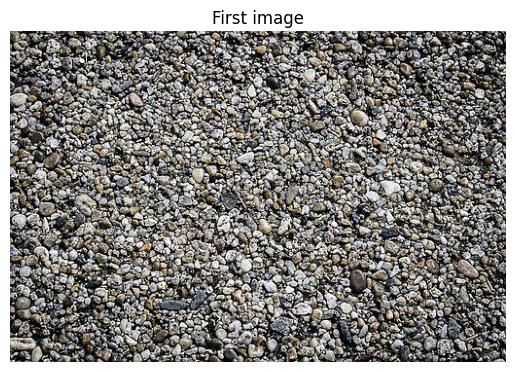

In [ ]:
print("Testing image reading with Matplotlib")
try:
  test_path = df.iloc[0]['path']
  img_array = mpimg.imread(test_path)
  print(f"Successfully read: {test_path}")
  print(f"Data type: {type(img_array)}")
  print(f"Dimensions (Shape): {img_array.shape}")
  plt.imshow(img_array)
  plt.axis('off')
  plt.title("First image")
  plt.show()
except Exception as e:
  print(f"Error reading image: {e}")

Class Distribution Statistics:
label
Pebbles    2743
Shells     1541
Name: count, dtype: int64


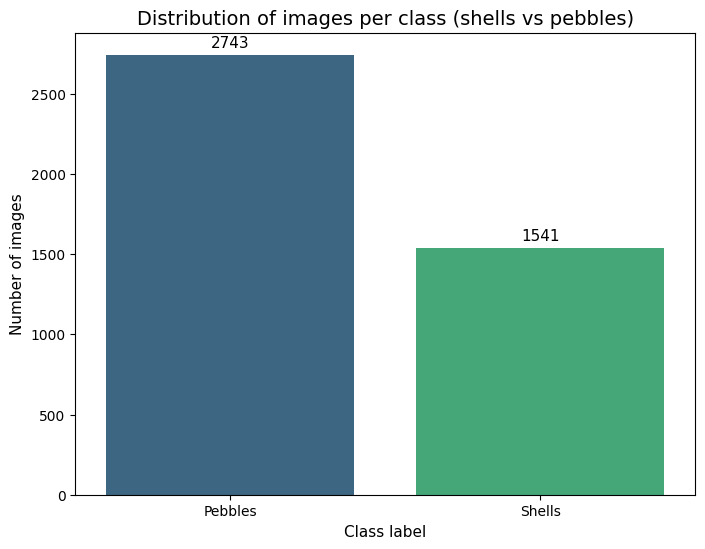

In [ ]:
label_counts = df['label'].value_counts()
print("Class Distribution Statistics:")
print(label_counts)
plt.figure(figsize=(8,6))
ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis', hue=label_counts.index, legend=False)
plt.title("Distribution of images per class (shells vs pebbles)", fontsize=14)
plt.xlabel('Class label', fontsize=11)
plt.ylabel('Number of images', fontsize=11)
for container in ax.containers:
  ax.bar_label(container, fontsize=11,padding =3)
plt.show()

Displaying 5 random samples for each class


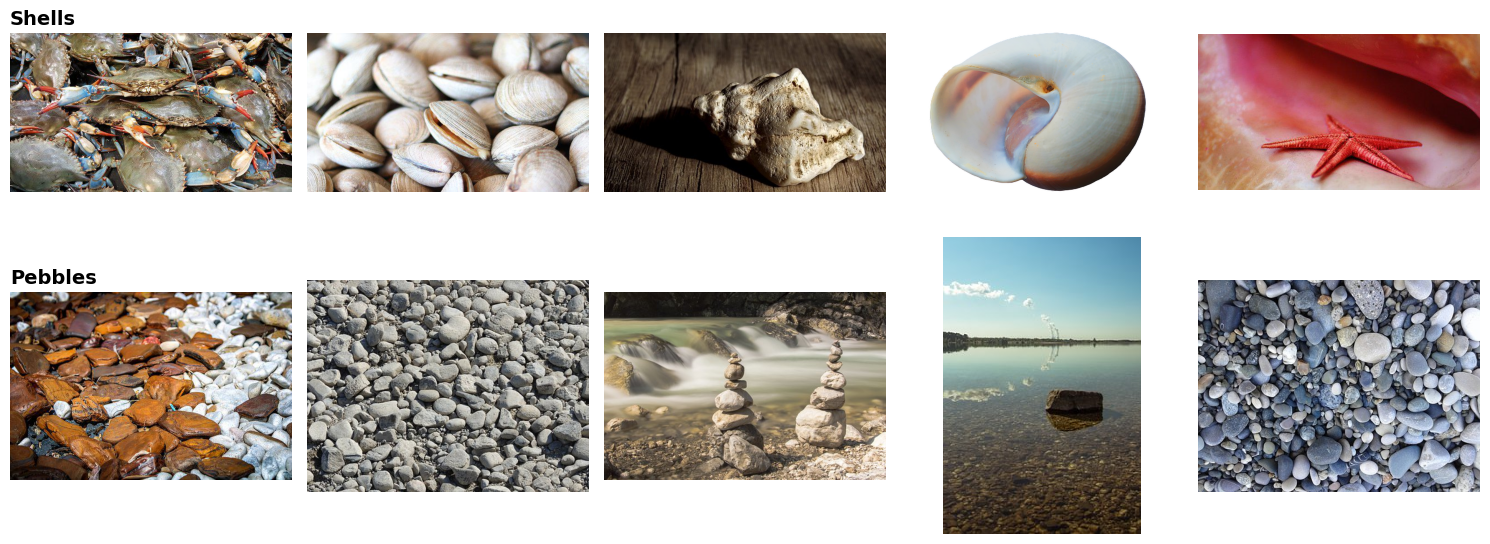

In [ ]:
def visualize_samples(df, num_samples=5):
  unique_labels = df['label'].unique()
  n_classes = len(unique_labels)
  fig, axes = plt.subplots(n_classes, num_samples, figsize=(15, 3*n_classes))
  print(f"Displaying {num_samples} random samples for each class")
  for i, label in enumerate(unique_labels):
    class_df = df[df['label'] == label]
    n_to_sample = min(num_samples, len(class_df))
    sampled_df = class_df.sample(n_to_sample)
    for j, (_, row) in enumerate(sampled_df.iterrows()):
      img_path = row['path']
      try:
        img_array = mpimg.imread(img_path)
        if n_classes > 1:
          ax = axes[i, j]
        else:
          ax = axes[j]
        ax.imshow(img_array)
        ax.axis('off')
        if j == 0:
          ax.set_title(label, fontsize=14, fontweight = 'bold', loc='left')
      except Exception as e:
        print(f"Error reading image {img_path}: {e}")

  plt.tight_layout()
  plt.show()

visualize_samples(df)


Image Dimensions

--- Checking dimensions for 100 random images ---
Average Width: 478
Average Height: 340
            width  height
count  100.000000   100.0
mean   477.580000   340.0
std     92.869973     0.0
min    174.000000   340.0
25%    453.000000   340.0
50%    510.000000   340.0
75%    510.000000   340.0
max    739.000000   340.0


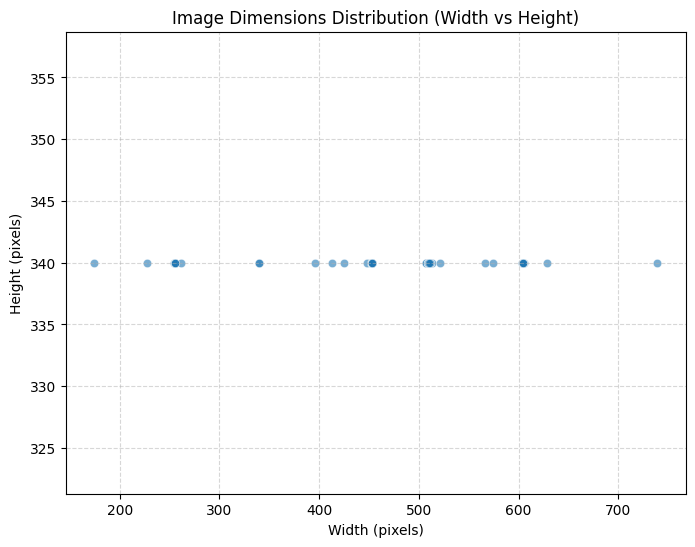

In [ ]:
def check_image_dimensions(df, sample_size=100):
    print(f"--- Checking dimensions for {sample_size} random images ---")

    widths = []
    heights = []

    sample_df = df.sample(min(sample_size, len(df)), random_state=42)

    for img_path in sample_df['path']:
        try:
            img_array = mpimg.imread(img_path)
            h, w, _ = img_array.shape

            widths.append(w)
            heights.append(h)
        except Exception:
            pass

    dim_df = pd.DataFrame({'width': widths, 'height': heights})

    print(f"Average Width: {dim_df['width'].mean():.0f}")
    print(f"Average Height: {dim_df['height'].mean():.0f}")
    print(dim_df.describe())

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=dim_df, x='width', y='height', alpha=0.6)
    plt.title('Image Dimensions Distribution (Width vs Height)')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Height (pixels)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

check_image_dimensions(df)

In [ ]:
from PIL import Image

def resize_image(img, target_w, target_h):
    if img.dtype != np.uint8:
        if img.max() <= 1.0:
            img_uint8 = (img * 255).astype(np.uint8)
        else:
            img_uint8 = img.astype(np.uint8)
    else:
        img_uint8 = img

    pil_img = Image.fromarray(img_uint8)
    resized_pil = pil_img.resize((target_w, target_h), Image.BILINEAR)
    return np.array(resized_pil)

def resize_with_pad(image, target_size):
    h, w = image.shape[:2]
    min_dim = min(h, w)

    start_x = (w - min_dim) // 2
    start_y = (h - min_dim) // 2

    cropped_image = image[start_y : start_y+min_dim, start_x : start_x+min_dim]
    final_image = resize_image(cropped_image, target_size, target_size)

    return final_image.astype(np.float32)

In [ ]:
def train_test_split(X, Y, paths, test_size=0.2, random_state=42):
    print(f"\n--Train/Test Split (Test Ratio={test_size})--")
    n_samples = len(X)
    indices = np.arange(n_samples)

    np.random.seed(random_state)
    np.random.shuffle(indices)

    split_idx = int(n_samples * (1 - test_size))
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]

    return (X[train_indices], X[test_indices],
            Y[train_indices], Y[test_indices],
            paths[train_indices], paths[test_indices])

Starting processing 4284 images (Target: 150x150)...
  -> 50 images processed out of 4284
  -> 100 images processed out of 4284
  -> 150 images processed out of 4284
  -> 200 images processed out of 4284
  -> 250 images processed out of 4284
  -> 300 images processed out of 4284
  -> 350 images processed out of 4284
  -> 400 images processed out of 4284
  -> 450 images processed out of 4284
  -> 500 images processed out of 4284
  -> 550 images processed out of 4284
  -> 600 images processed out of 4284
  -> 650 images processed out of 4284
  -> 700 images processed out of 4284
  -> 750 images processed out of 4284
  -> 800 images processed out of 4284
  -> 850 images processed out of 4284
  -> 900 images processed out of 4284
  -> 950 images processed out of 4284
  -> 1000 images processed out of 4284
  -> 1050 images processed out of 4284
  -> 1100 images processed out of 4284
  -> 1150 images processed out of 4284
  -> 1200 images processed out of 4284
  -> 1250 images processed out 

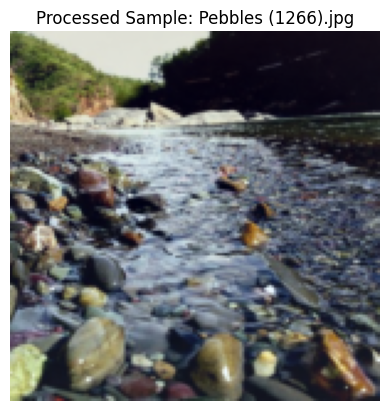

In [ ]:
IMG_SIZE = 150

def process_pipeline(df):
    data = []
    labels = []
    paths = []
    total_images = len(df)
    error_count = 0

    print(f"Starting processing {total_images} images (Target: {IMG_SIZE}x{IMG_SIZE})...")

    if total_images == 0:
        print("There is nothing in the DataFrame!!!")
        return None

    for i, (_, row) in enumerate(df.iterrows()):
        img_path = row['path']
        label_name = row['label']
        try:
            img = mpimg.imread(img_path)

            if len(img.shape) == 2:
                img = np.stack((img,)*3, axis=-1)
            elif img.shape[2] == 4:
                img = img[:, :, :3]

            img = resize_with_pad(img, IMG_SIZE)

            if img.max() > 1.0:
                img = img / 255.0

            data.append(img)
            labels.append(label_name)
            paths.append(img_path)

        except Exception as e:
            if error_count < 5:
                print(f"Error while reading image {img_path}: {str(e)}")
            error_count += 1
            pass

        if (i + 1) % 50 == 0:
            print(f"  -> {i + 1} images processed out of {total_images}")

    if len(data) == 0:
        print("\n🛑 CRITICAL ERROR: No images were processed successfully!")
        return None

    X = np.array(data, dtype=np.float32)
    Y_raw = np.array(labels)
    P_raw = np.array(paths)

    print(f"\nProcessing complete! Original Data Shape: {X.shape}")

    unique_labels = np.unique(Y_raw)
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    print("Label Encoding Map:", label_map)
    Y = np.array([label_map[l] for l in Y_raw])

    n_samples = X.shape[0]
    X_flat = X.reshape(n_samples, -1)

    X_train, X_test, Y_train, Y_test, P_train, P_test = train_test_split(
        X_flat, Y, P_raw, test_size=0.2, random_state=42
    )

    print("-> Applying Manual Standardization (Mean=0, Std=1)...")
    mean_val = np.mean(X_train, axis=0)
    std_val = np.std(X_train, axis=0) + 1e-8

    X_train = (X_train - mean_val) / std_val
    X_test = (X_test - mean_val) / std_val

    return X_train, X_test, Y_train, Y_test, label_map, P_train, P_test

if 'df' in locals():
    result = process_pipeline(df)

    if result is not None:
        X_train, X_test, Y_train, Y_test, label_map, P_train, P_test = result
        print("\n---------------- FINAL RESULTS ----------------")
        print(f"X_train: {X_train.shape}")
        print(f"y_train: {Y_train.shape}")
        print(f"X_test:  {X_test.shape}")
        print(f"y_test:  {Y_test.shape}")

        print("\nVisualizing sample (Reconstructed):")
        sample = X_train[0].reshape(IMG_SIZE, IMG_SIZE, 3)
        sample_display = (sample - sample.min()) / (sample.max() - sample.min())

        plt.imshow(sample_display)
        plt.title(f"Processed Sample: {P_train[0].split('/')[-1]}")
        plt.axis('off')
        plt.show()
    else:
        print("Program stopped due to data processing errors.")
else:
    print("Variable 'df' not found. Please run Step 1 (File Listing) first.")

In [ ]:
class NonLinearSVM:
  def __init__ (self, learning_rate=0.00001, lambda_param=0.001, n_iters=1000, decay_rate=0.001, use_poly=False):
    self.lr = learning_rate
    self.lambda_param = lambda_param
    self.n_iters = n_iters
    self.decay_rate = decay_rate
    self.use_poly = use_poly
    self.w = None
    self.b = None
    self.losses = []

  def _transform_poly(self, X):
    if self.use_poly:
      X_poly = np.concatenate((X, X**2), axis=1)
      mean = np.mean(X_poly, axis=0)
      std = np.std(X_poly, axis=0) + 1e-8
      return (X_poly - mean) / std
    return X

  def fit (self, X, Y):
    X = self._transform_poly(X)
    n_samples, n_features = X.shape
    np.random.seed(42)
    self.w = np.random.randn(n_features) * 0.01
    self.b = 0
    initial_lr = self.lr

    for i in range(self.n_iters):
      current_lr = initial_lr / (1 + self.decay_rate * i)
      indices = np.arange(n_samples)
      np.random.shuffle(indices)
      X_shuffled = X[indices]
      Y_shuffled = Y[indices]
      for idx, x_i in enumerate(X_shuffled):
        y_i = Y_shuffled[idx]
        condition = y_i * (np.dot(x_i, self.w) - self.b) >= 1
        if condition:
          self.w -= current_lr * (2 * self.lambda_param * self.w)
        else:
          gradient_w = 2 * self.lambda_param * self.w - np.dot(x_i, y_i)
          self.w -= current_lr * gradient_w
          self.b -= current_lr * y_i

      if i % 50 == 0:
        cost = self._compute_cost(X, Y)
        self.losses.append(cost)
        if i % 100 == 0:
          print(f"Epoch {i}/{self.n_iters} - LR: {current_lr:.6f} - Loss: {cost:.4f}")

  def predict (self, X):
    X = self._transform_poly(X)
    return np.sign(np.dot(X, self.w) - self.b)

  def _compute_cost(self, X, Y):
    distances = 1 - Y * (np.dot(X, self.w) - self.b)
    distances[distances < 0] = 0
    hinge_loss = np.mean(distances)
    return self.lambda_param * np.dot(self.w, self.w) + hinge_loss

In [ ]:
def accuracy(Y_true, Y_pred):
  correct_predictions = np.sum(Y_true == Y_pred)
  total_samples = len(Y_true)
  return correct_predictions/total_samples

def confusion_matrix(Y_true, Y_pred):
  TP = np.sum((Y_true == 1) & (Y_pred == 1)) #Shells right
  TN = np.sum((Y_true == -1) & (Y_pred == -1)) #Pebbles right
  FP = np.sum((Y_true == -1) & (Y_pred == 1)) #Pebbles false
  FN = np.sum((Y_true == 1) & (Y_pred == -1)) #Shells false
  return np.array([[TN, FP],
                   [FN, TP]])

In [ ]:
class PCA_FromScratch:
  def __init__ (self, n_components):
    self.n_components = n_components
    self.components = None
    self.mean = None
    self.std = None
    self.explained_variance_ratio = None

  def fit (self, X):
    print(f"-> Calculating PCA for datashape {X.shape} using SVD...")
    self.mean = np.mean(X, axis=0)
    self.std = np.std(X, axis=0) + 1e-8
    X_scaled = (X - self.mean)/self.std
    _, S, Vt = np.linalg.svd(X_scaled, full_matrices=False)
    self.components = Vt[:self.n_components]
    eigenvalues = S ** 2 / (X.shape[0] - 1)
    self.explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
    print(f"-> Found the most important components!")

  def transform (self, X):
    X_scaled = (X - self.mean)/self.std
    return np.dot(X_scaled, self.components.T)

N_COMPONENTS = 200
print(f"\nSTARTING PCA PIPELINE (Compressing {X_train.shape[1]} -> {N_COMPONENTS})")
pca = PCA_FromScratch(n_components = N_COMPONENTS)
pca.fit(X_train)
total_variance_kept = np.sum(pca.explained_variance_ratio) * 100
print(f"\n-> Total variance kept: {total_variance_kept:.2f}%")
print("-> Transforming data...")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Old shape: {X_train.shape}")
print(f"New shape: {X_train_pca.shape}")


STARTING PCA PIPELINE (Compressing 67500 -> 200)
-> Calculating PCA for datashape (3427, 67500) using SVD...
-> Found the most important components!

-> Total variance kept: 100.00%
-> Transforming data...
Old shape: (3427, 67500)
New shape: (3427, 200)



TRAINING SVM WITH PCA DATA
Epoch 0/3000 - LR: 0.000002 - Loss: 0.9974
Epoch 100/3000 - LR: 0.000002 - Loss: 0.8124
Epoch 200/3000 - LR: 0.000002 - Loss: 0.7289
Epoch 300/3000 - LR: 0.000002 - Loss: 0.6858
Epoch 400/3000 - LR: 0.000001 - Loss: 0.6636
Epoch 500/3000 - LR: 0.000001 - Loss: 0.6519
Epoch 600/3000 - LR: 0.000001 - Loss: 0.6453
Epoch 700/3000 - LR: 0.000001 - Loss: 0.6409
Epoch 800/3000 - LR: 0.000001 - Loss: 0.6377
Epoch 900/3000 - LR: 0.000001 - Loss: 0.6354
Epoch 1000/3000 - LR: 0.000001 - Loss: 0.6335
Epoch 1100/3000 - LR: 0.000001 - Loss: 0.6320
Epoch 1200/3000 - LR: 0.000001 - Loss: 0.6307
Epoch 1300/3000 - LR: 0.000001 - Loss: 0.6297
Epoch 1400/3000 - LR: 0.000001 - Loss: 0.6287
Epoch 1500/3000 - LR: 0.000001 - Loss: 0.6279
Epoch 1600/3000 - LR: 0.000001 - Loss: 0.6271
Epoch 1700/3000 - LR: 0.000001 - Loss: 0.6264
Epoch 1800/3000 - LR: 0.000001 - Loss: 0.6258
Epoch 1900/3000 - LR: 0.000001 - Loss: 0.6252
Epoch 2000/3000 - LR: 0.000001 - Loss: 0.6247
Epoch 2100/3000 - 

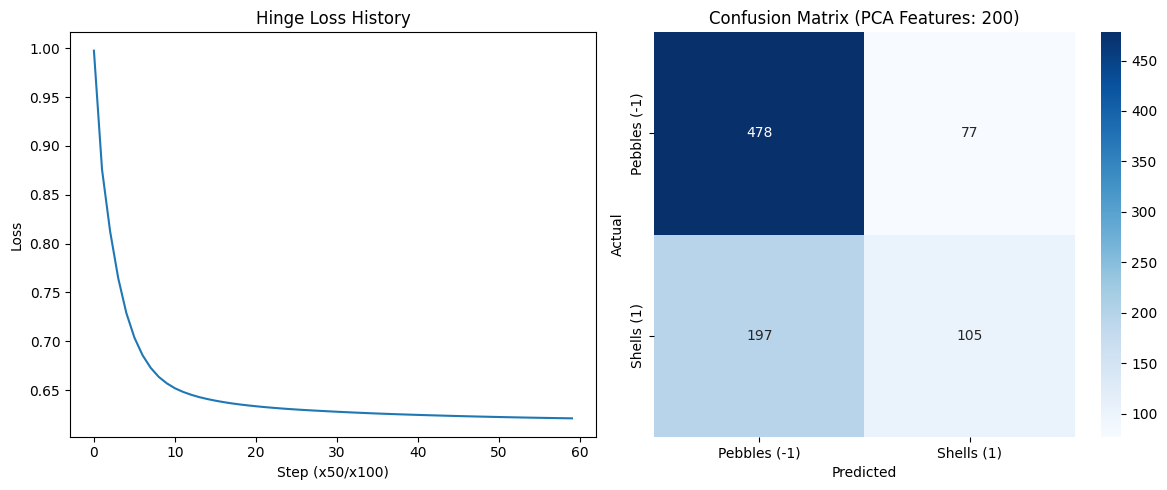

In [ ]:
print("\nTRAINING SVM WITH PCA DATA")
Y_train_svm = np.where(Y_train == 0, -1, 1)
Y_test_svm = np.where(Y_test == 0, -1, 1)
model_poly = NonLinearSVM(learning_rate=0.000002, lambda_param=0.0005, n_iters=3000, decay_rate = 0.001, use_poly=True)
model_poly.fit(X_train_pca, Y_train_svm)
print("SVM Training Completed!")

pred_pca = model_poly.predict(X_test_pca)
acc_pca = accuracy(Y_test_svm, pred_pca)

print(f"\n---> ACCURACY: {acc_pca * 100:.2f}%")
cm_pca = confusion_matrix(Y_test_svm, pred_pca)
print("\n---> CONFUSION MATRIX:")
print(cm_pca)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(model_poly.losses)
plt.title("Hinge Loss History")
plt.xlabel("Step (x50/x100)")
plt.ylabel("Loss")
plt.subplot(1,2,2)
sns.heatmap(cm_pca, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pebbles (-1)', 'Shells (1)'],
            yticklabels=['Pebbles (-1)', 'Shells (1)'])
plt.title(f"Confusion Matrix (PCA Features: {N_COMPONENTS})")
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.tight_layout()
plt.show()